In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns

# Networks of Neurons Creating Canard Explosions

We had read [1] that networks of exitatory and inhibitory neurons can produce canard explosions surprisingly easily.

The forementioned paper [1] discussed coupling only excitatory Three Dimensional Hodgkin-Huxley Neurons. The paper does not discuss finding this behavior with different types of neurons.

We decided it would be interesting to explore what that meant in a system context and discuss our results.

In [65]:
def alpha_h(v):
    return 0.07*np.exp(-(v+65)/20)
def beta_h(v):
    return 1 / ( 1 + np.exp(-(v+35)/10) )

def alpha_m(v):
    return (0.1 * (v + 40)) / (1 - np.exp(-(v+40)/10))
def beta_m(v):
    return 4*np.exp(-(v+40)/10)
def m_inf(v):
    return alpha_m(v) / (alpha_m(v) + alpha_m(v))

def alpha(v):
    alpha_0 = 2
    V_shp = 5
    return alpha_0 / ( 1 + np.exp(-v / V_shp) )

def f_Vh(v, h, g_Na, g_K, g_L, V_Na, V_k, V_L, I_0):
    n = 0.801 - 1.03*h
    return I_0 - g_Na*h*(v - V_Na)*m_inf(v)**3 - g_K*(v - V_k)*n(h)**4 - g_L*(v - V_L)

def HH_ThreeDim_Coupled(t, u, g_Na, g_K, g_L, g_syn, V_Na, V_k, V_L, V_syn, I_0, tau_syn):
    v = u[0]
    h = u[1]
    s = u[2]

    dVdt = f_Vh(v, h, g_Na, g_K, g_L, V_Na, V_k, V_L, I_0) - g_syn * s*(v - V_syn)
    dhdt = alpha_h(v) * (1 - h) - beta_h(v)*h
    dsdt = alpha(v) * (1 - s) - s/tau_syn

    return [dVdt, dhdt, dsdt]

In [66]:
# Parameters
C = 1.0
phi = 1.0
alpha0 = 2.0
Vshp = 5.0

# Functions
def m_inf(V):
    return (0.1 * phi * (V + 40)) / (1 - np.exp(-(V + 40) / 10)) / \
           ((0.1 * phi * (V + 40)) / (1 - np.exp(-(V + 40) / 10)) + 4 * phi * np.exp(-(V + 65) / 18))

def h_inf(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def tau_h(V):
    return 1 / (0.07 * phi * np.exp(-(V + 65) / 20) + phi / (1 + np.exp(-(V + 35) / 10)))

def alpha(V):
    return alpha0 / (1 + np.exp(-V / Vshp))

def n_func(h):
    return np.maximum(0.87 - h, 0)

def reduced_HH(t, y, gNa = 120.0, gK = 36.0, gL = 0.3, VNa = 50.0, VK = -77.0, VL = -54.4, I0 = 13.0, gsyn = 1.0, Vsyn = 0.0, tausyn = 20.0):
    V, h, s = y
    m = m_inf(V)
    n = n_func(h)
    dVdt = (-gL*(V - VL) - gK*(n**4)*(V - VK) - gNa*(m**3)*h*(V - VNa)
            + I0 - gsyn*s*(V - Vsyn)) / C
    dhdt = (h_inf(V) - h) / tau_h(V)
    dsdt = alpha(V)*(1 - s) - s / tausyn
    return [dVdt, dhdt, dsdt]

In [67]:
# Initial conditions
V0 = -65.0
h0 = h_inf(V0)
s0 = 0.0
y0 = [V0, h0, s0]

t_span = (0, 300) # ms
t_eval = np.linspace(t_span[0], t_span[1], 1000)

sol = solve_ivp(reduced_HH, t_span, y0, method='RK45', rtol=1e-8, atol=1e-6)

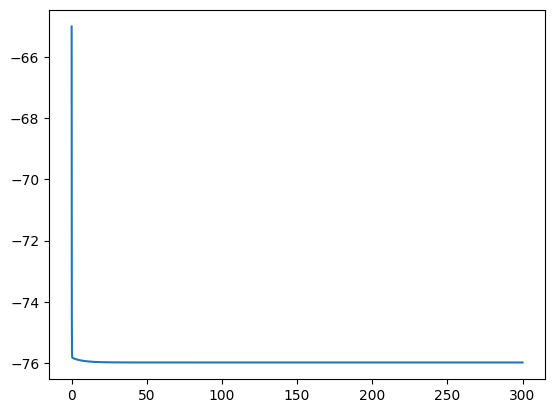

In [68]:
plt.plot(sol.t, sol.y[0], label='Membrane Voltage V(t)')
plt.show()

## References

[1] J. Drover, J. Rubin, J. Su, and B. Ermentrout, Analysis of a canard mechanism by which 
excitatory synaptic coupling can synchronize neurons at low ﬁring frequencies, SIAM J. Appl. Math, 65 (2004), pp. 69–92.